In [79]:
%matplotlib inline
import math
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import os
import re
from collections import Counter
import numpy as np
from visualization import TrainingVisualizer

In [80]:
# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [81]:
# 设置阈值
threshold = 5

# 加载文本数据
with open('data/time_machine_txt/timemachine.txt', 'r') as f:
    text = f.read()

# 将所有字符转换为小写
text = text.lower()

# 移除所有标点符号
text = re.sub(r'[^\w\s]', '', text)  # 仅保留字母、数字和空格
# 截取前 n 个字符
n = 3000
text = text[:n]

# 计算字符的词频
char_counts = Counter(text)

# 创建字符映射表，保留词频不低于阈值的字符，其他字符设为<unk>
chars = sorted([ch for ch, count in char_counts.items() if count >= threshold])
chars.append('<unk>')  # 添加<unk>标记

char_to_idx = {ch: idx for idx, ch in enumerate(chars)}
idx_to_char = {idx: ch for idx, ch in enumerate(chars)}
unk_idx = char_to_idx['<unk>']

# 转换文本为索引，如果字符词频低于阈值，则转换为<unk>
text_as_int = np.array([char_to_idx.get(c, unk_idx) for c in text])

# 打印结果示例
print("Unique characters:", len(chars))
print("Character to Index mapping:", char_to_idx)
print("First 100 characters as indices:", text_as_int[:10])

Unique characters: 27
Character to Index mapping: {'\n': 0, ' ': 1, '_': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, '<unk>': 26}
First 100 characters as indices: [20 10  7  1 20 11 14  7  1 14]


In [92]:
# 定义超参数
vocab_size = len(chars)  # 字符的个数
seq_size = 50  # 序列长度 - 一个句子100个单词
batch_size = 128
hidden_size = 256
embedding_size = 64  # input_size 嵌入向量的大小
num_layers = 3
lr = 0.01
num_epochs = 50000

In [93]:
def create_dataset(text_as_int, seq_size, batch_size):
    sequences = []
    targets = []
    for i in range(0, len(text_as_int) - seq_size):
        sequences.append(text_as_int[i:i + seq_size])
        targets.append(text_as_int[i + 1:i + seq_size + 1])
    sequences = torch.tensor(sequences, dtype=torch.long)
    targets = torch.tensor(targets, dtype=torch.long)
    dataset = torch.utils.data.TensorDataset(sequences, targets)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    return dataloader

dataloader = create_dataset(text_as_int, seq_size, batch_size)

In [94]:
def initialize_DeepRNN_Wb(embedding_size, hidden_size, vocab_size, num_layers, device):
    """
    hidden_size：神经元个数
    注意：
    1. 第一个隐藏层的我们需要处理的输入的维度为：(batch_size, embedding_size)。
    2. 而后面的隐藏层，根据“每个隐状态都连续地传递到当前层的下一个时间步和下一层的当前时间步”，后面的隐藏层需要处理的输入的size = 第一个隐藏层的输出size - (batch_size, hidden_size)
    """
    params = []
    input_size = embedding_size
    # 初始化隐藏层参数
    for layer in range(num_layers):
        W_xh =  torch.normal(0, 1, (input_size, hidden_size), device = device) * 0.01
        W_hh = torch.normal(0, 1, (hidden_size, hidden_size), device = device) * 0.01
        b_h = torch.zeros((1, hidden_size), device = device) 
        hidden_layer_params = [W_xh, W_hh, b_h]
        params.append(hidden_layer_params)
        input_size = hidden_size

    # 输出层参数
    W_hq = torch.normal(0, 1, (hidden_size, vocab_size), device = device) * 0.01
    b_q = torch.zeros((1, vocab_size), device = device)
    output_layer_params = [W_hq, b_q]
    params.append(output_layer_params)

    # 附加梯度
    for layer_params in params:
        for param in layer_params:
            param.requires_grad_(True)
    
    return params # 长度为 num_layers+1 的二维list

In [95]:
def initialize_DeepRNN_H(batch_size, hidden_size, num_layers, device):
    DeepRNN_H_list = []
    for layer in range(num_layers):
        H = torch.zeros((batch_size, hidden_size), device = device)
        DeepRNN_H_list.append(H)
    return DeepRNN_H_list # 包含 num_layers 个张量的list

In [96]:
def DeepRNN_calculate(inputs, params, DeepRNN_H_list, num_layers, device): # inputs的形状：(seq_size，batch_size, embedding_size)；输入的H应该也是一个list，包含num_layers个张量        
    outputs = []
    W_hq, b_q = params[-1]
    for X in inputs: # X的形状：(batch_size, embedding_size)
        input_tensor = X # 第一个隐藏层的输入是X，之后的隐藏层输入都是H
        for layer in range(num_layers):
            W_xh, W_hh, b_h = params[layer]
            DeepRNN_H_list[layer] = torch.tanh(torch.mm(input_tensor, W_xh) + torch.mm(DeepRNN_H_list[layer], W_hh) + b_h)
            input_tensor = DeepRNN_H_list[layer]
        O = torch.mm(DeepRNN_H_list[num_layers-1], W_hq) + b_q
        outputs.append(O) # outputs是每一个时间步的输出 - [tensor(batch_size, vocab_size), tensor(batch_size, vocab_size), ......]
        
    outputs = torch.stack(outputs)
    return outputs, DeepRNN_H_list # outputs 的 size：(seq_size, batch_size, vocab_size)

In [97]:
class DeepRNNModel(nn.Module):
    def __init__(self, embedding_size, hidden_size, vocab_size, num_layers, initialize_DeepRNN_Wb, initialize_DeepRNN_H, DeepRNN_calculate, device):
        super(DeepRNNModel, self).__init__()
        self.device = device
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.params = initialize_DeepRNN_Wb(embedding_size, hidden_size, vocab_size, num_layers, device)
        self.initialize_DeepRNN_H = initialize_DeepRNN_H
        self.DeepRNN_calculate = DeepRNN_calculate

    def forward(self, X, DeepRNN_H_list): 
        # 输入的X的形状为：(batch_size, seq_size)；DeepRNN_H_list的形状为：[(batch_size, hidden_size), (batch_size, hidden_size), ...]
        X = self.embedding(X) # 此时X的形状变为：(batch_size, seq_size, embedding_size)
        X = X.permute(1, 0, 2).to(self.device) # 此时X的形状变为：(seq_size, batch_size, embedding_size)
        Y, DeepRNN_H_list = self.DeepRNN_calculate(X, self.params, DeepRNN_H_list, self.num_layers, self.device)
        return Y, DeepRNN_H_list # 返回Y的size：(seq_size, batch_size, vocab_size)

    def begin_H(self, batch_size, hidden_size, device):
        return self.initialize_DeepRNN_H(batch_size, hidden_size, self.num_layers, device)

In [98]:
def grad_clipping(net, theta):
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm # 整体进行一个缩放

In [99]:
def DeepRNN_train_epoch(train_iter, model, criterion, optimizer, device):
    DeepRNN_H_list = None
    
    for X, Y in train_iter: # X，Y的形状：(batch_size, seq_size)
        
        if DeepRNN_H_list is None: # 如果处于第一个迭代周期
            DeepRNN_H_list = model.begin_H(X.shape[0], hidden_size, device)
        else: 
            DeepRNN_H_list = [H.detach() for H in DeepRNN_H_list]

        Y = Y.T # Y的size从(batch_size, seq_size) -> (seq_size, batch_size)
        Y_hat, DeepRNN_H_list = model(X, DeepRNN_H_list) # Y_hat的size：(seq_size, batch_size, vocab_size)
        # 为了计算交叉熵损失，我们需要调整Y_hat和Y的size，这也是课本代码中使用reshape的原因
        Y_hat = Y_hat.reshape(-1, Y_hat.shape[2]) # size变成：(seq_size*batch_size, vocab_size)
        Y = Y.reshape(-1) # 把Y变为一维的张量
        Y_hat, Y = Y_hat.to(device), Y.to(device)

        optimizer.zero_grad()
        loss = criterion(Y_hat, Y.long()).mean()
        loss.backward()
        grad_clipping(model, 1)
        optimizer.step()

        perplexity = math.exp(loss)
        
    return perplexity

In [100]:
def DeepRNN_train(model, train_iter, lr, num_epochs, device):
    """训练模型"""
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)
    visualizer = TrainingVisualizer(xlabel='Epoch', ylabel='Perplexity', title='Train DeepRNN_scratch in Time_Machine', legend=['Perplexity'])  

    predict = lambda prefix: text_prediction(prefix, 50, model, device) # 匿名函数，输入prefix预测50个token
    
    # 训练和预测
    for epoch in range(num_epochs):
        perplexity = DeepRNN_train_epoch(train_iter, model, criterion, optimizer, device)
        visualizer.add(epoch, [perplexity])

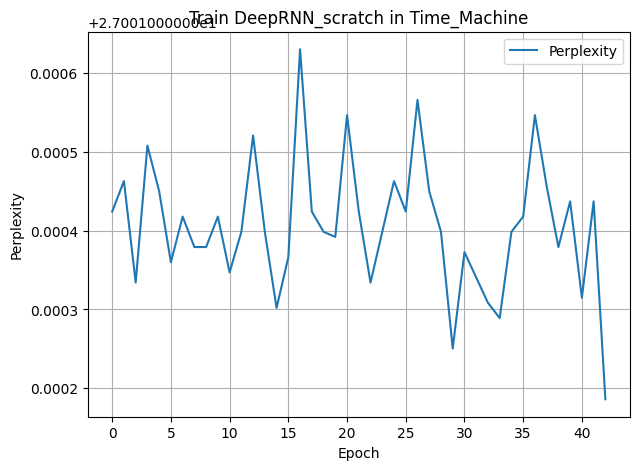

In [ ]:
model = DeepRNNModel(embedding_size, hidden_size, vocab_size, num_layers, initialize_DeepRNN_Wb, initialize_DeepRNN_H, DeepRNN_calculate, device)

DeepRNN_train(model, dataloader, lr, num_epochs, device)